In [42]:
from transformers import AutoTokenizer, BertModel
import torch
from torch import nn

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
last_hidden_states.shape

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([1, 8, 768])

In [12]:
outputs.pooler_output.shape, outputs.last_hidden_state.shape

(torch.Size([1, 768]), torch.Size([1, 8, 768]))

In [43]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [7]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min = 1e-9)
        mean_embeddings = sum_embeddings/sum_mask
        return mean_embeddings

In [15]:
pooling = MeanPooling()
pooling(
    outputs.last_hidden_state,
    inputs['attention_mask']
).shape

torch.Size([1, 768])

In [16]:
class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim = 1)
        return max_embeddings

In [17]:
pooling = MaxPooling()
pooling(
    outputs.last_hidden_state,
    inputs['attention_mask']
).shape

torch.Size([1, 768])

In [18]:
class MinPooling(nn.Module):
    def __init__(self):
        super(MinPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = 1e-4
        min_embeddings, _ = torch.min(embeddings, dim = 1)
        return min_embeddings

In [ ]:
pooling = MinPooling()
pooling(
    outputs.last_hidden_state,
    inputs['attention_mask']
).shape

In [20]:
class WeightedLayerPooling(nn.Module):
    def __init__(self, num_hidden_layers, layer_start: int = 4, layer_weights = None):
        super(WeightedLayerPooling, self).__init__()
        self.layer_start = layer_start
        self.num_hidden_layers = num_hidden_layers
        self.layer_weights = layer_weights if layer_weights is not None \
            else nn.Parameter(
                torch.tensor([1] * (num_hidden_layers+1 - layer_start), dtype=torch.float)
            )

    def forward(self, ft_all_layers):
        all_layer_embedding = torch.stack(ft_all_layers)
        all_layer_embedding = all_layer_embedding[self.layer_start:, :, :, :]

        weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
        weighted_average = (weight_factor*all_layer_embedding).sum(dim=0) / self.layer_weights.sum()

        return weighted_average

In [21]:
class AttentionPooling(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, 1),
        )

    def forward(self, last_hidden_state, attention_mask):
        w = self.attention(last_hidden_state).float()
        w[attention_mask==0]=float('-inf')
        w = torch.softmax(w,1)
        attention_embeddings = torch.sum(w * last_hidden_state, dim=1)
        return attention_embeddings

In [22]:
pooling = AttentionPooling(768)
pooling(
    outputs.last_hidden_state,
    inputs['attention_mask']
).shape

torch.Size([1, 768])

In [23]:
from transformers import AutoTokenizer, BertModel, BertForTokenClassification
import torch
from torch import nn

# https://github.com/huggingface/transformers/blob/v4.31.0/src/transformers/models/bert/modeling_bert.py#L1714
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertForTokenClassification.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: 

In [37]:
class CustomModel(nn.Module):
    def __init__(self, dropout=0.5, hidden_size=768, ner_labels=2, cls_labels=2):
        super().__init__()
        
        self.model = BertModel.from_pretrained("bert-base-uncased", add_pooling_layer=True)
        
        # N * 768
        # 输出1：输入句子（论文标题 + 作者 + 摘要），是否属于医疗论文 
        # 输出2：输入句子（论文标题 + 作者 + 摘要），token是否属于关键词
        
        self.dropout = nn.Dropout(dropout)
        self.ner_classifier = nn.Linear(hidden_size, ner_labels)
        self.cls_classifier = nn.Linear(hidden_size, cls_labels)

    def forward(self, inputs):
        x = self.model(**inputs) # N * 768
        last_hidden_state = self.dropout(x.last_hidden_state) # N * 768
        pooler_output = self.dropout(x.pooler_output) # 768
        
        # N * 1, 1 * 1
        return self.ner_classifier(last_hidden_state), self.cls_classifier(pooler_output)

In [41]:
model = CustomModel()
model(inputs)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(tensor([[[ 0.1398, -0.1411, -0.5449,  0.3980, -0.5029, -0.1461,  0.2369],
          [ 0.1099,  0.3858,  0.1143, -0.0414,  0.2208, -0.3372, -0.1269],
          [ 0.7342, -0.0498,  0.0217, -0.2936, -0.6614, -0.1703,  0.3990],
          [-0.5091,  0.1077, -0.1556, -0.0939, -0.4533,  0.1493, -0.4606],
          [ 0.0137, -0.4307, -0.1346, -0.1324, -0.0216, -0.5262, -0.0139],
          [ 0.3150,  0.1485, -0.2055, -0.3929,  0.2718, -1.0493, -0.7699],
          [ 0.5080,  0.0542,  0.4397,  0.1461, -0.2352,  0.3424, -0.3224],
          [ 0.0177, -0.1848,  0.1060,  0.2489,  0.1444,  0.2606, -0.7421]]],
        grad_fn=<ViewBackward0>),
 tensor([[-0.6640,  0.7882]], grad_fn=<AddmmBackward0>))

https://maartengr.github.io/KeyBERT/

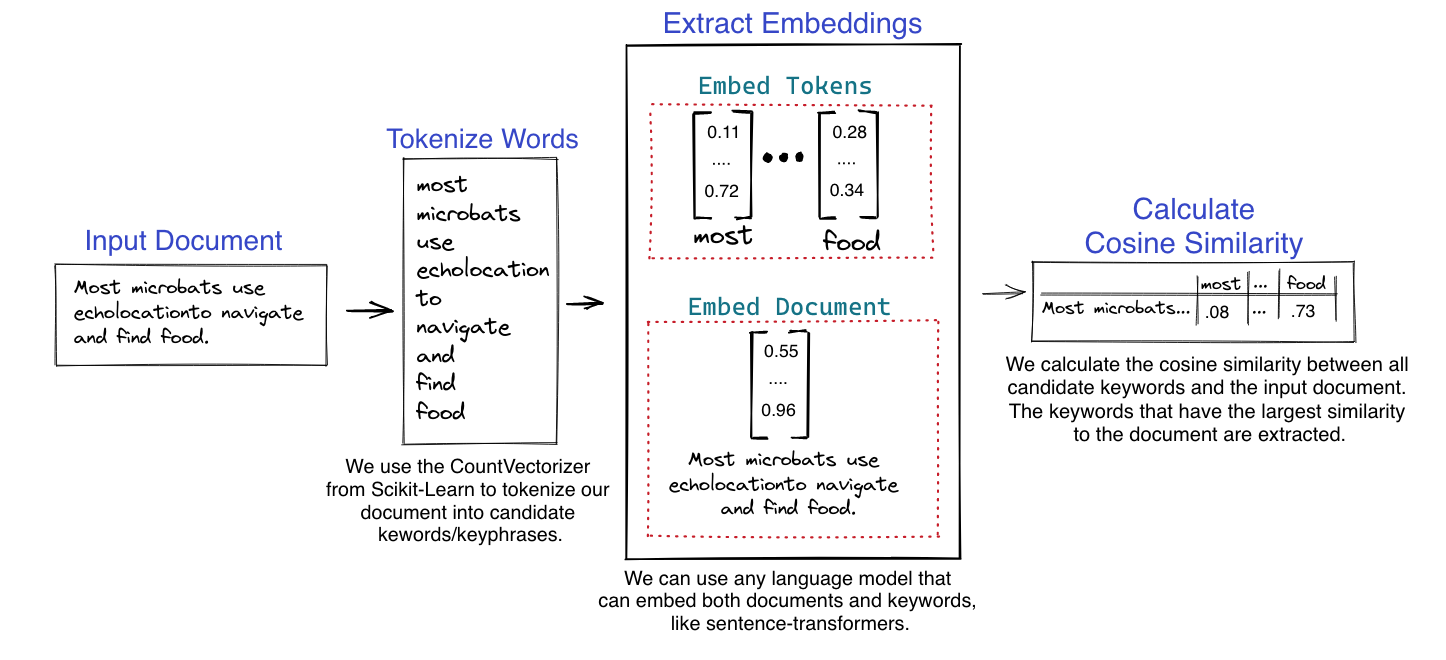